## Likelihood-free estimation of stop model parameters

This notebook shows how to use approximate Bayesian computation via sequential Monte Carlo (ABC-SMC) using the pyABC package.

In [1]:
# imports

import pyabc
import json
from pprint import pprint
from pyabc import (ABCSMC,
                   RV, Distribution)
import numpy as np
import scipy.stats as st
import os
import pandas as pd
import matplotlib.pyplot as plt
from ssd import fixedSSD
from stoptaskstudy import StopTaskStudy

%matplotlib inline



In [8]:
# create a single-layer metrics dict for output
# since the pickler can't handle multilevel dicts
def cleanup_metrics(metrics):
    for k in metrics['SSRT']:
        metrics['SSRT_' + k] = metrics['SSRT'][k]
    del metrics['SSRT']
    return(metrics)


def stopsignal_model(parameters):
    paramfile = 'params.json'
    with open(paramfile) as f:
            params = json.load(f)
    # install the parameters from the simulation
    parameters['nondecision'] = int(parameters['nondecision'])
    params['mu']['go'] = parameters['mu_go']
    params['mu']['stop'] = parameters['mu_go'] + parameters['mu_stop_delta']
    params['mu_delta_incorrect']  = parameters['mu_delta_incorrect']
    params['noise_sd'] = {'go': parameters['noise_sd'],
                          'stop': parameters['noise_sd']}
    params['nondecision'] = {'go': parameters['nondecision'],
                             'stop': parameters['nondecision']}
    #print(params)
    # TBD
    #    if args.p_guess_file is not None:
    #        p_guess = pd.read_csv(args.p_guess_file, index_col=0)
    #        assert 'SSD' in p_guess.columns and 'p_guess' in p_guess.columns

    #    if args.random_seed is not None:
    #        np.random.seed(args.random_seed)

    min_ssd, max_ssd, ssd_step = 0, 550, 50
    ssd = fixedSSD(np.arange(min_ssd, max_ssd + ssd_step, ssd_step))

    study = StopTaskStudy(ssd, None, params=params)

    trialdata = study.run()
    metrics = study.get_stopsignal_metrics()
    # summarize data - go trials are labeled with SSD of -inf so that
    # they get included in the summary
    stop_data = trialdata.groupby('SSD').mean().query('SSD >= 0').resp.values
    results = {}
    
    metrics = cleanup_metrics(metrics)
    for k in [ 'mean_go_RT', 'mean_stopfail_RT', 'go_acc']:
        results.update({k: metrics[k]})
    for i, value in enumerate(stop_data):
        results[f'presp_{i}'] = value

    return(results)



In [9]:
# load history from db file
history = pyabc.History('sqlite:///adaptive_distance.db')
print(history.id)

1


In [10]:
observed_presp = pd.read_csv('presp_by_ssd_inperson.txt',  delimiter=r"\s+", index_col=0)

observed_data = {'mean_go_RT': 455.367, 'mean_stopfail_RT': 219.364, 'go_acc': .935}
for i, value in enumerate(observed_presp.presp.values):
    observed_data[f'presp_{i}'] = value



In [11]:
plot_kde = False
if plot_kde:
    fig, ax = plt.subplots()
    for t in range(history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            xmin=0, xmax=1,
            x="mu_go", ax=ax,
            label="PDF t={}".format(t))
    #ax.axvline(observed_presp.presp.values, color="k", linestyle="dashed");
    ax.legend();


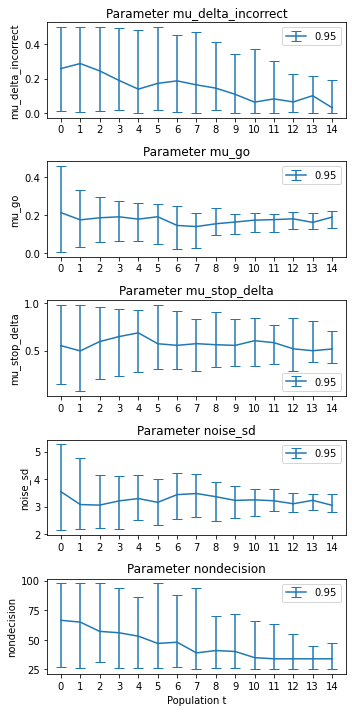

In [12]:
plot_ci = True
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,10))
if plot_ci:
    ci_ax = pyabc.visualization.plot_credible_intervals(history, arr_ax=axes)
    def get_map_estimates(ci_ax):
        map_estimates = {}
        for ax in ci_ax:
            map_estimates[ax.get_ylabel()] = ax.get_lines()[0].get_ydata()[-1]
        return(map_estimates)
    map_estimates = get_map_estimates(ci_ax)


{'mu_delta_incorrect': 0.03318890047425279,
 'mu_go': 0.1891107384840534,
 'mu_stop_delta': 0.5174876480002678,
 'noise_sd': 3.0504467383435223,
 'nondecision': 34.0}
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
mean_go_RT 388.40040609137054 455.367
mean_stopfail_RT 304.6143572621035 219.364
go_acc 0.7898477157360406 0.935


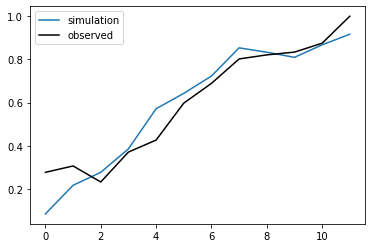

In [13]:
pprint(map_estimates)

simulation = stopsignal_model(map_estimates)

for k in simulation:
     if not k.find('presp')>-1:
         print(k, simulation[k], observed_data[k])
plot_presp = True
if plot_presp:
    simulation['presp'] = []
    for i in range(12):
        simulation['presp'].append(simulation[f'presp_{i}'])
    plt.plot(simulation['presp'])
    plt.plot(observed_presp.presp.values, 'k')
    plt.legend(['simulation', 'observed'])


In [14]:
simulation

{'mean_go_RT': 393.7901437371663,
 'mean_stopfail_RT': 316.68465430016863,
 'go_acc': 0.6997946611909651,
 'presp_0': 0.10843373493975904,
 'presp_1': 0.19753086419753085,
 'presp_2': 0.2857142857142857,
 'presp_3': 0.40476190476190477,
 'presp_4': 0.5180722891566265,
 'presp_5': 0.6707317073170732,
 'presp_6': 0.6904761904761905,
 'presp_7': 0.7142857142857143,
 'presp_8': 0.7619047619047619,
 'presp_9': 0.8795180722891566,
 'presp_10': 0.9285714285714286,
 'presp_11': 0.9404761904761905}

In [31]:
history.db_file()

'adaptive_distance.db'